In [1]:
# Import the necessary libraries
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(PROJ_DIR,'src'))
import xai_faithfulness_experiments_lib_edits as fl
import numpy as np
import captum_generator as cg
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

DATASET = 'imagenet'
MODEL_NAME = 'resnet18-logits'

network = fl.load_pretrained_imagenet_model(arch = MODEL_NAME.replace('-logits', ''), use_logits = '-logits' in MODEL_NAME)
DATA_MEAN = torch.tensor([0.485, 0.456, 0.406]).reshape((3,1,1)).to(device)
DATA_STD = torch.tensor([0.229, 0.224, 0.225]).reshape((3,1,1)).to(device)

import pickle

FILENAME = f'{DATASET}_{MODEL_NAME}_noise_exceptionals.pkl'

with open(os.path.join(PROJ_DIR, 'results', FILENAME), 'rb') as fIn:
    results = pickle.load(fIn)

elem = results[10]

from matplotlib import pyplot as plt

def fix_image(im, denorm=True):
    if denorm:
        im = im*DATA_STD + DATA_MEAN
    return np.moveaxis(im.detach().cpu().numpy(), 0, -1)


Using cuda:0
Loading Resnet18


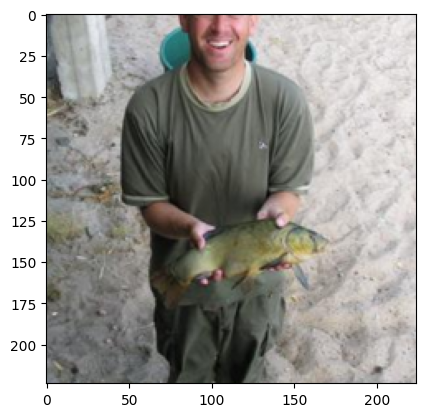

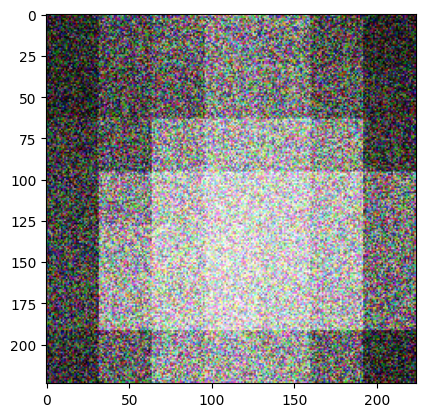

In [2]:
plt.imshow(fix_image(elem['row']))
plt.show()
plt.imshow(fix_image(elem['inverse_ranking'], False))
plt.show()

/home/eirasf/miniconda3/envs/xai-anna/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/eirasf/miniconda3/envs/xai-anna/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


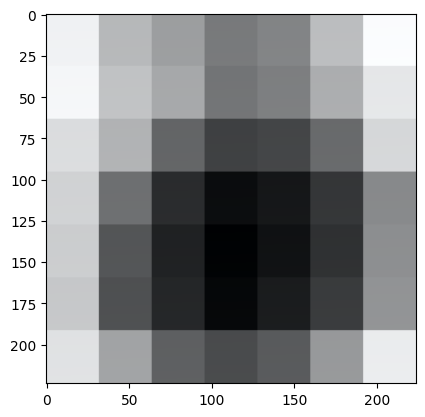

In [3]:
captum_rankings = torch.tensor(cg.generate_rankings(elem['row'], elem['label'], network)).to(device)
ranking = captum_rankings[-2]
plt.imshow(fix_image(ranking, denorm=False))
plt.show()

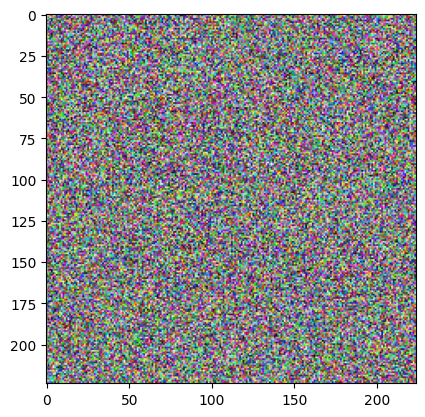

In [4]:
random_ranking = fl._get_random_ranking_row(elem['row'].shape)
plt.imshow(fix_image(random_ranking, denorm=False))
plt.show()

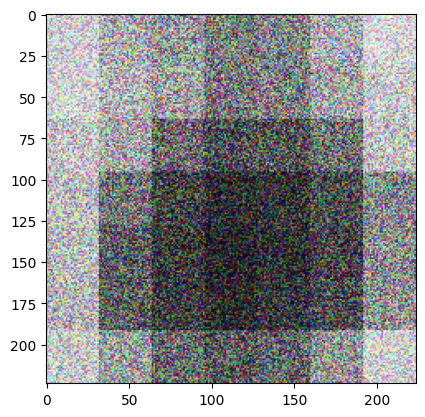

In [5]:
attributions = ranking + random_ranking
noisy_ranking = fl._attributions_to_ranking_row(attributions.flatten().detach().cpu().numpy())
noisy_ranking = torch.tensor(noisy_ranking.reshape(ranking.shape)).to(device)
plt.imshow(fix_image(noisy_ranking, denorm=False))
plt.show()


## Speed measurements for Quantus methods

In [92]:
import quantus
from tqdm import tqdm

x_batch_pt = torch.unsqueeze(elem['row'], dim=0)
x_batch = x_batch_pt.to('cpu').numpy()
y_batch = torch.unsqueeze(elem['label'], dim=0).to('cpu').numpy()


for _ in tqdm(range(1000)):
    a_batch = np.expand_dims(fl._get_random_ranking_row(elem['row'].shape).cpu().numpy(), 0)
    #22.6 it/s
    '''exp = quantus.FaithfulnessCorrelation(nr_runs=10,
                                    subset_size=4,  
                                    perturb_baseline="black",
                                    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
                                    similarity_func=quantus.similarity_func.correlation_pearson,  
                                    abs=False,  
                                    return_aggregate=False,
                                    disable_warnings=True
                                )(model=network, 
                                x_batch=x_batch, 
                                y_batch=y_batch,
                                a_batch=a_batch,
                                device=device,
                                channel_first=True)[0]
    '''
    #2.30 it/s
    '''exp = quantus.FaithfulnessEstimate(
                                        perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
                                        similarity_func=quantus.similarity_func.correlation_pearson,
                                        features_in_step=448,  
                                        perturb_baseline="black",
                                    disable_warnings=True
                                    )(model=network, 
                                    x_batch=x_batch, 
                                    y_batch=y_batch,
                                    a_batch=a_batch,
                                    device=device,)[0]
    '''
    #~8 s/it
    '''exp = quantus.RegionPerturbation(
                                        patch_size=14,
                                        regions_evaluation=10,
                                        perturb_baseline="uniform",  
                                        normalise=True,
                                    disable_warnings=True
                                    )(model=network, 
                                  x_batch=x_batch,
                                  y_batch=y_batch,
                                  a_batch=a_batch,
                                  device=device,)[0]
    '''
    #~7 it/s - No a_batch
    '''exp = quantus.LocalLipschitzEstimate(
                                        nr_samples=4,
                                        perturb_std=0.2,
                                        perturb_mean=0.0,
                                        norm_numerator=quantus.similarity_func.distance_euclidean,
                                        norm_denominator=quantus.similarity_func.distance_euclidean,    
                                        perturb_func=quantus.perturb_func.gaussian_noise,
                                        similarity_func=quantus.similarity_func.lipschitz_constant,
                                                                        disable_warnings=True
                                    )(model=network, 
                                    x_batch=x_batch,
                                    y_batch=y_batch,
                                    a_batch=None,    
                                    device=device,
                                    explain_func=quantus.explain, 
                                    explain_func_kwargs={"method": "Saliency"})[0]
    '''
    # 3.3 it/s - No a_batch
    '''exp = quantus.MaxSensitivity(
                                    nr_samples=10,
                                    lower_bound=0.2,
                                    norm_numerator=quantus.norm_func.fro_norm,
                                    norm_denominator=quantus.norm_func.fro_norm,
                                    perturb_func=quantus.perturb_func.uniform_noise,
                                    similarity_func=quantus.similarity_func.difference,
                                    disable_warnings=True
                                )(model=network, 
                                x_batch=x_batch,
                                y_batch=y_batch,
                                a_batch=None,
                                device=device,
                                explain_func=quantus.explain, 
                                explain_func_kwargs={"method": "Gradient"})[0]'''
    # 2.5 it/s
    '''exp = quantus.ModelParameterRandomisation(
                                            layer_order="bottom_up",
                                            similarity_func=quantus.similarity_func.correlation_spearman,
                                            normalise=True,
                                            disable_warnings=True
                                        )(model=network, 
                                        x_batch=x_batch,
                                        y_batch=y_batch,
                                        a_batch=None,
                                        explain_func=quantus.explain, 
                                        explain_func_kwargs={"method": "Saliency"}, 
                                        device=device)'''
    # 55 it/s - Always the same result??
    exp = quantus.EffectiveComplexity(
                                    eps=1e-5,
                                    disable_warnings=True
                                )(model=network, 
                                x_batch=x_batch,
                                y_batch=y_batch,
                                a_batch=a_batch,
                                device=device,
                                channel_first=True)


    print(exp)

  1%|          | 11/1000 [00:00<00:19, 51.33it/s]

[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]


  2%|▏         | 17/1000 [00:00<00:18, 52.37it/s]

[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]


  3%|▎         | 29/1000 [00:00<00:18, 53.32it/s]

[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]


  4%|▍         | 41/1000 [00:00<00:17, 53.56it/s]

[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]


  5%|▌         | 53/1000 [00:01<00:18, 52.12it/s]

[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]
[150526]


KeyboardInterrupt: 

In [95]:
quantus.EffectiveComplexity(
                                    eps=1e-5,
                                    disable_warnings=True
                                )(model=network, 
                                x_batch=x_batch,
                                y_batch=y_batch,
                                a_batch=np.expand_dims(ranking.cpu().numpy(),0),
                                device=device,
                                channel_first=True)

[150526]